In [ ]:
import json
import urllib.request

# Download ImageNet class labels (ID to human-readable name)
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
filename = "imagenet_class_index.json"
urllib.request.urlretrieve(url, filename)

# Load class labels
with open(filename, "r") as f:
    imagenet_labels = json.load(f)

# Convert ImageNet IDs to readable names
id_to_label = {v[0]: v[1].lower() for k, v in imagenet_labels.items()}
imagenet_id_to_idx = {v[0]: int(k) for k, v in imagenet_labels.items()}

# Print example mapping
print("Example mappings from ID to label:", list(id_to_label.items())[:5])


Example mappings from ID to label: [('n01440764', 'tench'), ('n01443537', 'goldfish'), ('n01484850', 'great_white_shark'), ('n01491361', 'tiger_shark'), ('n01494475', 'hammerhead')]


In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import drive
import zipfile
# ==============================
# 1. MOUNT GOOGLE DRIVE & UNZIP IMAGESET-MINI
# ==============================
drive.mount('/content/drive')

# Path to the uploaded ImageNet-Mini ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/imagenet-mini.zip"  # Modify this with your file's location
extract_path_all = "/content/imagenet_mini"

# Unzip ImageNet-Mini if not already extracted
if not os.path.exists(extract_path_all):
    print("Extracting ImageNet-Mini...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path_all)
    print("✅ Extraction Complete!")
else:
    print("✅ ImageNet-Mini is already extracted.")

import os
extract_path = "/content/imagenet_mini/train"
# Check available class names
print("Available classes:", os.listdir(extract_path))
# Get available classes (ImageNet IDs) from dataset
available_classes = os.listdir(extract_path)

# Convert ImageNet IDs to human-readable names
imagenet_classes = {cls_id: id_to_label.get(cls_id, cls_id) for cls_id in available_classes}

# Print mapped classes
print("Mapped Classes:", imagenet_classes)

# ==============================
# 2. LOAD IMAGENET SUBSET (144 Images)
# ==============================
selected_classes = [
    "ant", "corn", "jellyfish", "lemon", "lion", "mushroom", "snail", "zebra",
    "broom", "cello", "fountain", "harp", "laptop", "microphone",
    "pizza", "shovel", "tennis_ball", "umbrella"
]

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load ImageNet dataset from the extracted folder
dataset = datasets.ImageFolder(root=extract_path, transform=transform)

# Get the mapping of dataset integer labels to ImageNet class IDs
idx_to_class_id = {v: k for k, v in dataset.class_to_idx.items()}  # Reverse mapping



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ ImageNet-Mini is already extracted.
Available classes: ['n04476259', 'n02102177', 'n04258138', 'n01632458', 'n02892201', 'n01944390', 'n03032252', 'n03733131', 'n07930864', 'n04532670', 'n01734418', 'n06359193', 'n01950731', 'n04604644', 'n04525038', 'n01924916', 'n03445777', 'n01744401', 'n01748264', 'n04275548', 'n01695060', 'n03042490', 'n02980441', 'n02120079', 'n02669723', 'n10565667', 'n03026506', 'n04613696', 'n03977966', 'n04553703', 'n02134418', 'n01580077', 'n01739381', 'n02422699', 'n02105855', 'n01873310', 'n04347754', 'n07716906', 'n07932039', 'n04141327', 'n04111531', 'n03544143', 'n02749479', 'n02097298', 'n04328186', 'n02835271', 'n03201208', 'n03838899', 'n02094114', 'n03337140', 'n02643566', 'n03483316', 'n02708093', 'n01729322', 'n03961711', 'n01795545', 'n06596364', 'n01689811', 'n04560804', 'n04467665', 'n04591713', 'n02441942', 'n07693

In [ ]:
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Map dataset class labels (WordNet ID -> ImageNet index 0-999)
dataset_wordnet_to_idx = {k: imagenet_id_to_idx.get(k, -1) for k in dataset.class_to_idx.keys()}

# Check if any class IDs were not found
missing_classes = [k for k, v in dataset_wordnet_to_idx.items() if v == -1]
print(f"⚠ Missing ImageNet Classes: {missing_classes}")

filtered_data = []
class_counts = {cls: 0 for cls in selected_classes}

for img, label in dataset:
    # Get the ImageNet WordNet ID
    wordnet_id = list(dataset.class_to_idx.keys())[label]

    # Convert WordNet ID to ImageNet index (0-999)
    imagenet_index = imagenet_id_to_idx.get(wordnet_id, None)

    # Ensure index is valid (0-999)
    if imagenet_index is not None and imagenet_index < 1000:
        cls_name = imagenet_labels[str(imagenet_index)][1]  # Get readable name

        if cls_name in selected_classes and class_counts[cls_name] < 8:
            filtered_data.append((img, imagenet_index))  # Store correct label
            class_counts[cls_name] += 1

print(f"✅ Total Images Selected: {len(filtered_data)} (Should be 144)")



⚠ Missing ImageNet Classes: []
✅ Total Images Selected: 144 (Should be 144)


In [ ]:
filtered_data

[(tensor([[[-1.9809, -1.9980, -2.0152,  ..., -2.0152, -2.0494, -2.0323],
           [-1.9980, -2.0665, -2.0494,  ..., -2.0152, -1.9809, -1.9295],
           [-1.9124, -1.9809, -2.0152,  ..., -2.0323, -1.9638, -1.9467],
           ...,
           [-1.6727, -1.6555, -1.5870,  ..., -1.9124, -1.9809, -1.9467],
           [-1.7240, -1.6555, -1.6898,  ..., -1.8610, -1.9467, -1.9809],
           [-1.6555, -1.5528, -1.6555,  ..., -2.0152, -1.9638, -2.0152]],
  
          [[-1.4580, -1.4055, -1.3880,  ..., -1.4930, -1.4580, -1.4405],
           [-1.4055, -1.3529, -1.3354,  ..., -1.4755, -1.4755, -1.4930],
           [-1.4580, -1.3880, -1.3704,  ..., -1.4755, -1.5105, -1.5105],
           ...,
           [-1.1779, -1.1779, -1.2129,  ..., -1.4055, -1.4405, -1.4580],
           [-1.1779, -1.1604, -1.1429,  ..., -1.4405, -1.4230, -1.4055],
           [-1.1779, -1.1779, -1.0903,  ..., -1.3880, -1.4230, -1.4230]],
  
          [[-1.2467, -1.2293, -1.2467,  ..., -1.2467, -1.3164, -1.3513],
           

✅ Total Images Selected: 144


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 56.9MB/s]
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


ResNet-50 Last Conv Layer: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
Xception Last Conv Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)

[ResNet-50] Batch Labels: tensor([486, 792, 951, 486, 562, 594, 620, 963])
✅ Corrected Target Class: 486


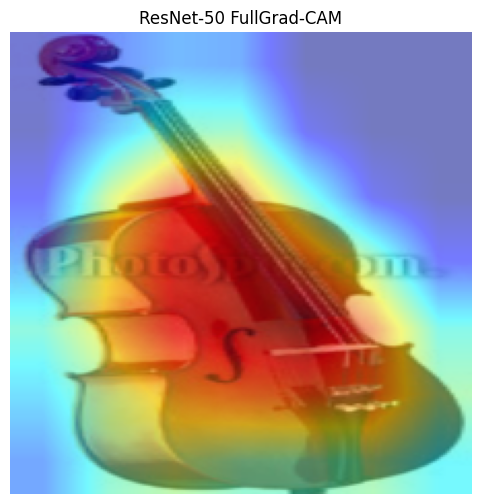

✅ Corrected Target Class: 792


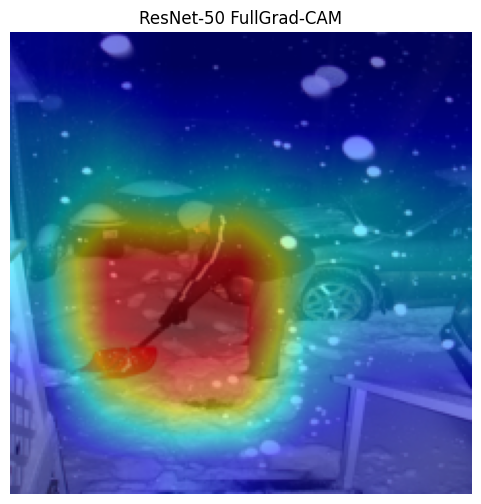

✅ Corrected Target Class: 951


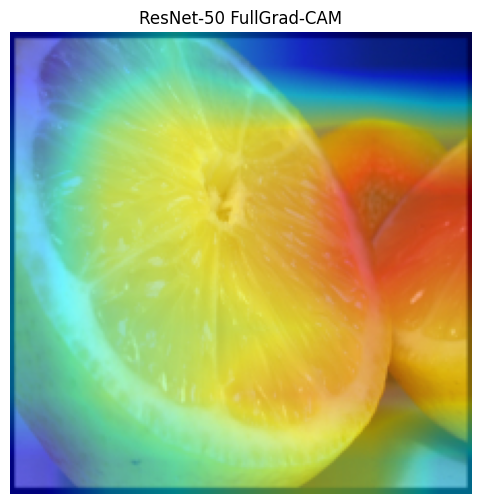

✅ Corrected Target Class: 486


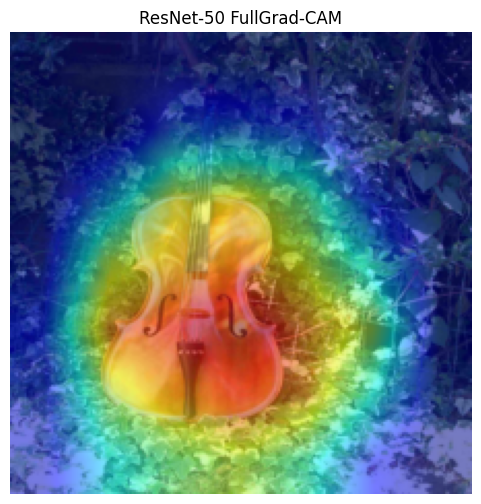

✅ Corrected Target Class: 562


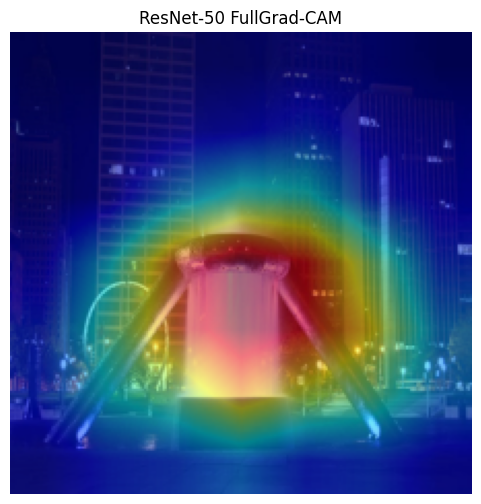

✅ Corrected Target Class: 594


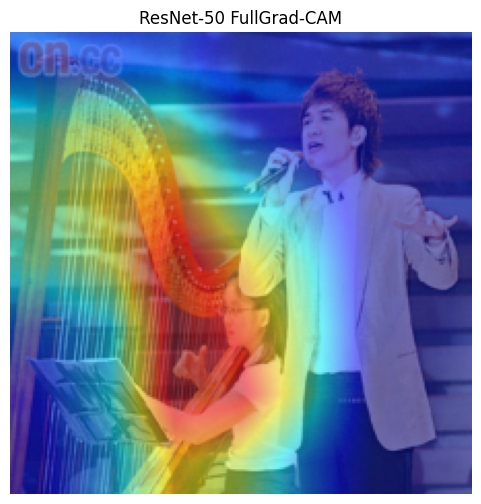

✅ Corrected Target Class: 620


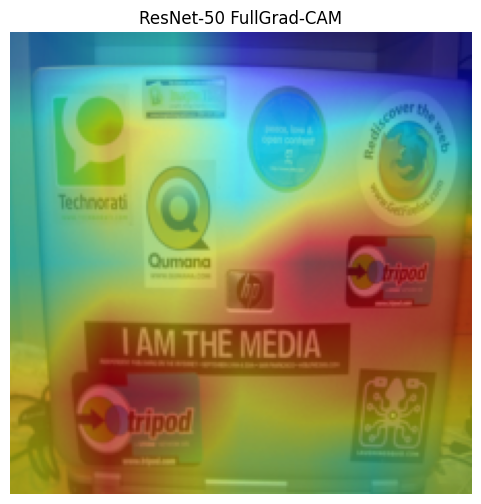

✅ Corrected Target Class: 963


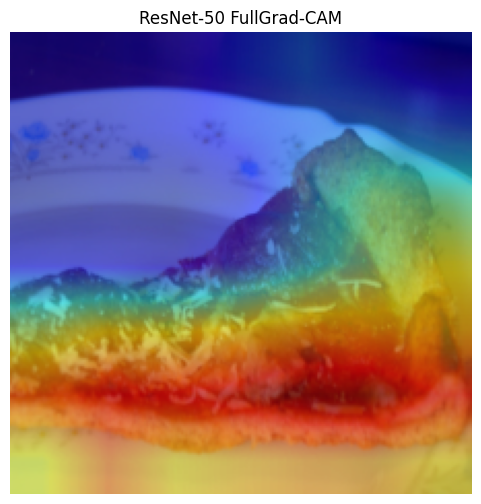


[Xception] Batch Labels: tensor([562, 340, 620, 113, 291, 879, 987, 947])
✅ Corrected Target Class: 562


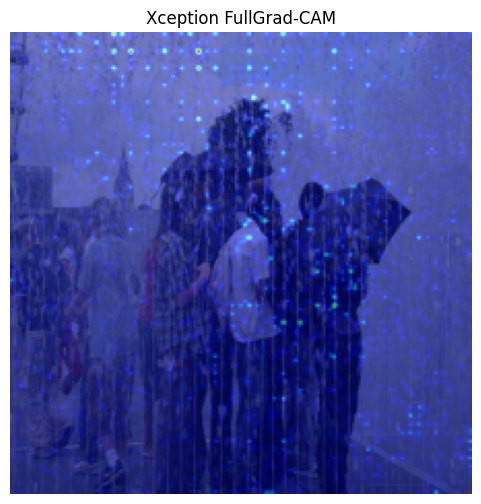

✅ Corrected Target Class: 340


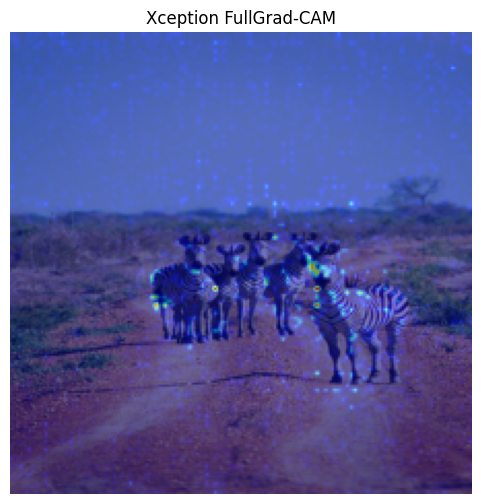

✅ Corrected Target Class: 620


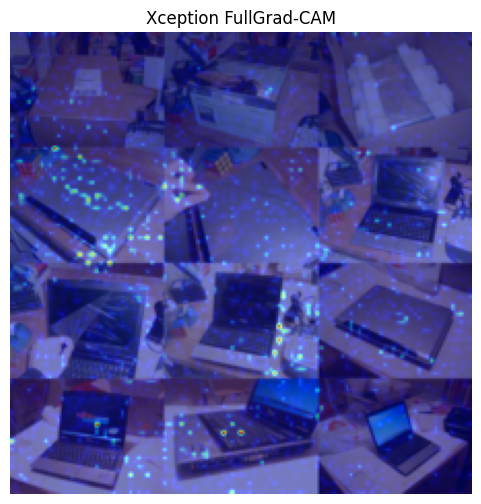

✅ Corrected Target Class: 113


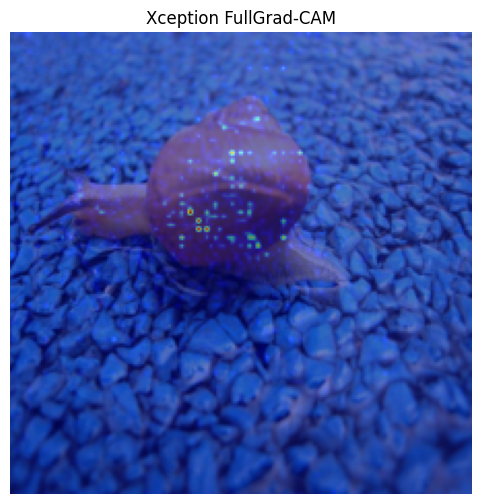

✅ Corrected Target Class: 291


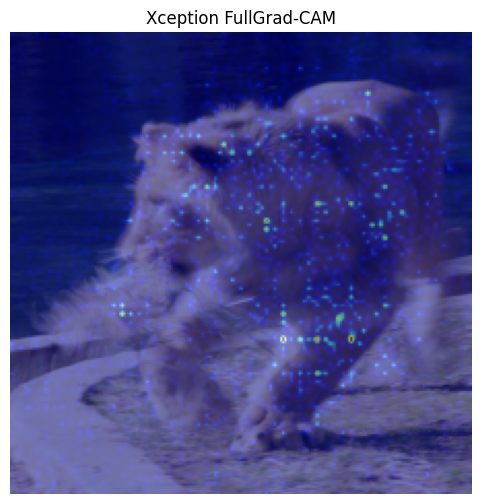

✅ Corrected Target Class: 879


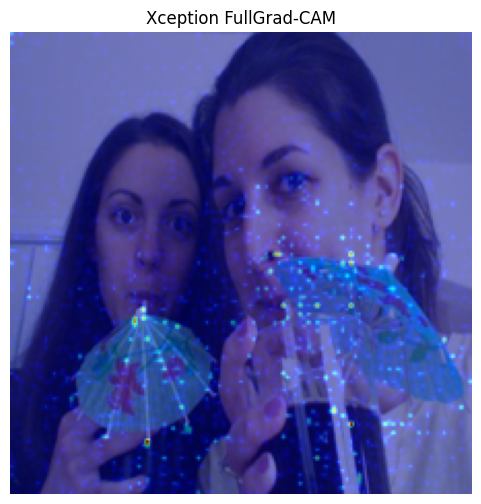

✅ Corrected Target Class: 987


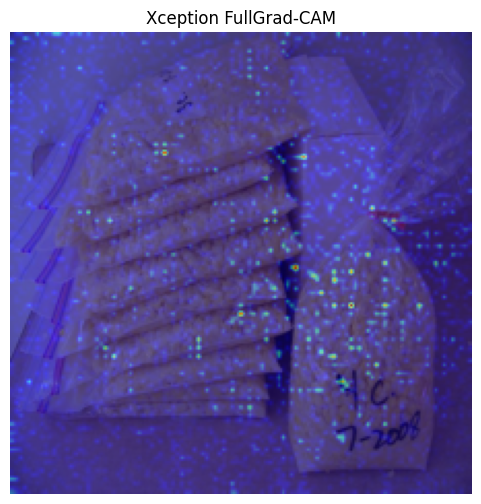

✅ Corrected Target Class: 947


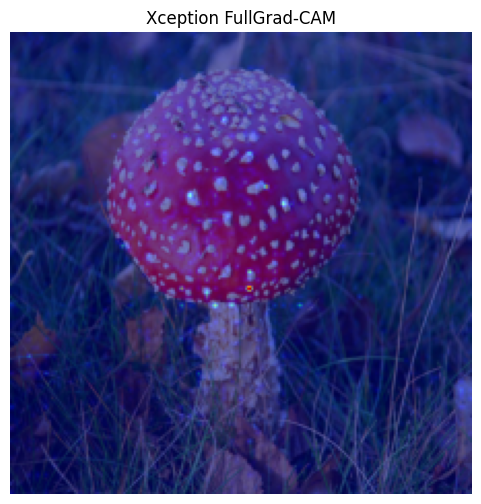

In [ ]:
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming dataset is already prepared
class ImageNetMiniDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Example data_loader (ensure your dataset is properly loaded)
data_loader = DataLoader(ImageNetMiniDataset(filtered_data), batch_size=8, shuffle=True)

print(f"✅ Total Images Selected: {len(filtered_data)}")

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device).eval()
xception = timm.create_model('xception', pretrained=True).to(device).eval()

# ==============================
# 2. FULLGRAD-CAM IMPLEMENTATION
# ==============================
class FullGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        """Hooks for capturing activations and gradients."""
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)  # Fix for future PyTorch versions

    def generate_cam(self, input_tensor, target_class=None):
        """Generate FullGrad-CAM heatmap."""
        self.model.zero_grad()
        output = self.model(input_tensor)

        # Ensure target class is within valid range
        if target_class is None or target_class >= 1000:
            target_class = output.argmax().item()

        print(f"✅ Corrected Target Class: {target_class}")

        loss = output[:, target_class].sum()
        loss.backward()

        # Ensure gradients and activations are captured
        if self.gradients is None or self.activations is None:
            print("❌ Error: Gradients or activations are None!")
            return None

        # Compute FullGrad-CAM
        cam = torch.sum(self.gradients * self.activations, dim=1).squeeze().detach().cpu().numpy()
        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize

        return cam

# ==============================
# 3. FIND LAST CONV LAYER FOR XCEPTION
# ==============================
def get_last_conv_layer(model):
    """Find the last convolutional layer in the model."""
    for layer in reversed(list(model.children())):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
        elif isinstance(layer, torch.nn.Sequential):  # Handle Sequential layers
            for sub_layer in reversed(list(layer.children())):
                if isinstance(sub_layer, torch.nn.Conv2d):
                    return sub_layer
    raise ValueError("No convolutional layer found!")

xception_last_layer = get_last_conv_layer(xception)

# ==============================
# 4. APPLY FULLGRAD-CAM TO MODELS
# ==============================
def run_fullgrad_cam(model, model_name, target_layer, data_loader):
    cam_extractor = FullGradCAM(model, target_layer)

    for images, labels in data_loader:
        images = images.to(device)

        print(f"\n[{model_name}] Batch Labels: {labels}")

        # Process one image at a time for visualization
        for i in range(len(images)):
            cam_map = cam_extractor.generate_cam(images[i].unsqueeze(0), target_class=labels[i].item())

            if cam_map is None:
                print("❌ Error: CAM generation failed. Skipping this image.")
                continue

            visualize_cam(images[i], cam_map, f"{model_name} FullGrad-CAM")

        break  # Process one batch and stop

# ==============================
# 5. VISUALIZE HEATMAPS
# ==============================
def visualize_cam(image_tensor, cam_map, title="FullGrad-CAM"):
    """Overlay CAM heatmap on input image."""
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)  # Convert to numpy
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    image = (image * 255).astype(np.uint8)  # Convert to uint8 for OpenCV

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

# ==============================
# 6. RUN FULLGRAD-CAM ON RESNET-50 & XCEPTION
# ==============================
print("ResNet-50 Last Conv Layer:", resnet.layer4[-1])
print("Xception Last Conv Layer:", xception_last_layer)

# Run FullGrad-CAM on dataset
run_fullgrad_cam(resnet, "ResNet-50", resnet.layer4[-1], data_loader)
run_fullgrad_cam(xception, "Xception", xception_last_layer, data_loader)

ResNet-50 Last Conv Layer: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
Xception Last Conv Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)

[ResNet-50] Batch Labels: tensor([620, 792, 113, 310, 107, 462, 650, 963])
Model Output Shape: torch.Size([8, 1000])
Predicted Class: 3310, Target Class Before Fix: 620
✅ Corrected Target Class: 620
Image Shape: (224, 224, 3), Heatmap Shape: (224, 224, 3)


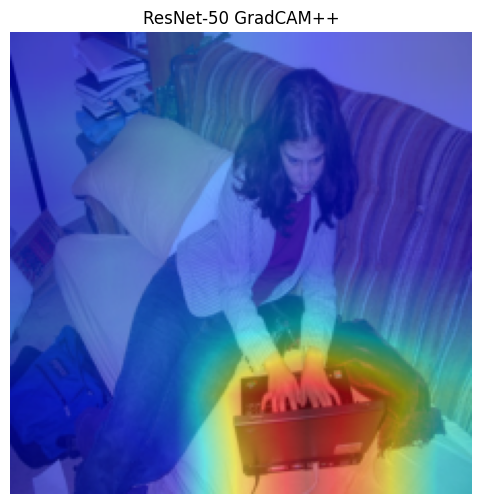


[Xception] Batch Labels: tensor([486, 852, 947, 947, 852, 620, 107, 987])
Model Output Shape: torch.Size([8, 1000])
Predicted Class: 2997, Target Class Before Fix: 486
✅ Corrected Target Class: 486
Image Shape: (224, 224, 3), Heatmap Shape: (224, 224, 3)


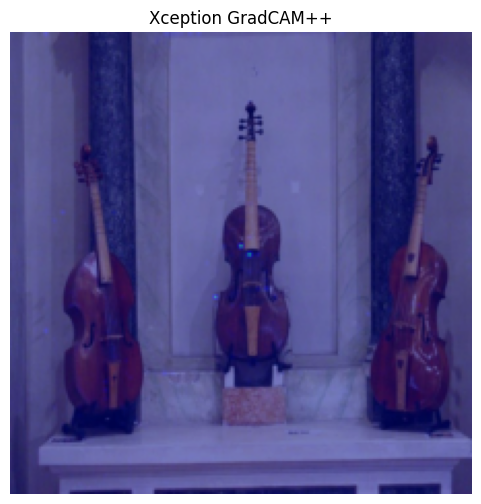

In [ ]:
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)  # FIXED HOOK

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        print(f"Model Output Shape: {output.shape}")  # Should be (batch_size, 1000)
        print(f"Predicted Class: {output.argmax().item()}, Target Class Before Fix: {target_class}")

        # Fix invalid target class
        if target_class is None or target_class >= 1000:
            target_class = output.argmax().item()

        print(f"✅ Corrected Target Class: {target_class}")  # Should be 0-999

        self.model.zero_grad()
        loss = output[:, target_class].sum()
        loss.backward()

        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()

        # Compute GradCAM++ weighting coefficients
        alpha = np.sum(gradients, axis=(2, 3), keepdims=True)
        alpha = gradients / (2 * alpha + 1e-10)
        weights = np.maximum(alpha, 0) * gradients  # ReLU applied to weights

        cam = np.sum(weights * activations, axis=1)  # Weighted sum of activations
        cam = np.maximum(cam, 0)  # ReLU

        # Normalize CAM
        cam = (cam - np.min(cam)) / (np.max(cam) + 1e-10)
        return cam[0]
def get_last_conv_layer(model):
    for layer in reversed(list(model.children())):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    raise ValueError("No convolutional layer found!")

# Extract last convolutional layers
resnet_last_layer = resnet.layer4[-1]
xception_last_layer = get_last_conv_layer(xception)

print("ResNet-50 Last Conv Layer:", resnet_last_layer)
print("Xception Last Conv Layer:", xception_last_layer)
def visualize_cam(image_tensor, cam_map, title="GradCAM++"):
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    image = (image * 255).astype(np.uint8)  # Convert to uint8

    # Ensure cam_map is resized to match the image size
    cam_map = cv2.resize(cam_map, (image.shape[1], image.shape[0]))  # ✅ Fix size mismatch
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Ensure both images have the same shape
    print(f"Image Shape: {image.shape}, Heatmap Shape: {heatmap.shape}")  # Debugging check

    overlay = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)  # ✅ Fix shape mismatch

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(title)
    plt.show()


def run_gradcam_plus(model, model_name, target_layer):
    cam_extractor = GradCAMPlusPlus(model, target_layer)

    for images, labels in data_loader:
        images = images.to(device)

        print(f"\n[{model_name}] Batch Labels: {labels}")

        cam_map = cam_extractor.generate_cam(images, target_class=labels[0].item())

        if cam_map is None:
            print("❌ Error: CAM generation failed. Skipping this batch.")
            continue

        visualize_cam(images[0], cam_map, f"{model_name} GradCAM++")
        break

# Run GradCAM++ on both models
run_gradcam_plus(resnet, "ResNet-50", resnet.layer4[-1])
run_gradcam_plus(xception, "Xception", xception_last_layer)


✅ Corrected Target Class: 879
Model Output Shape: torch.Size([1, 1000])
Predicted Class: 879, Target Class Before Fix: 879
✅ Corrected Target Class: 879


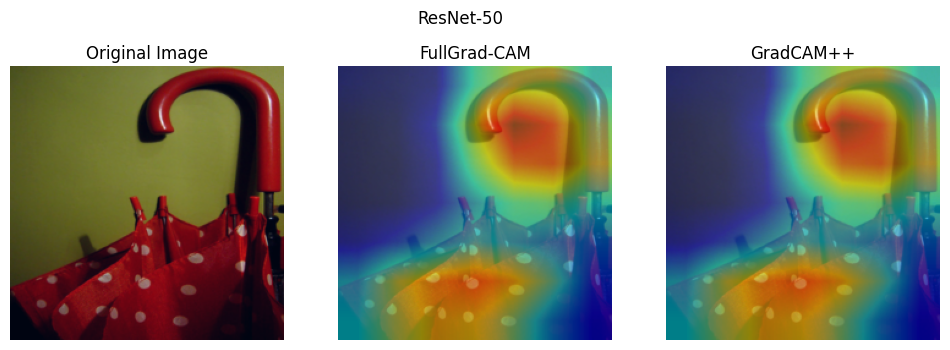

✅ Corrected Target Class: 879
Model Output Shape: torch.Size([1, 1000])
Predicted Class: 600, Target Class Before Fix: 879
✅ Corrected Target Class: 879


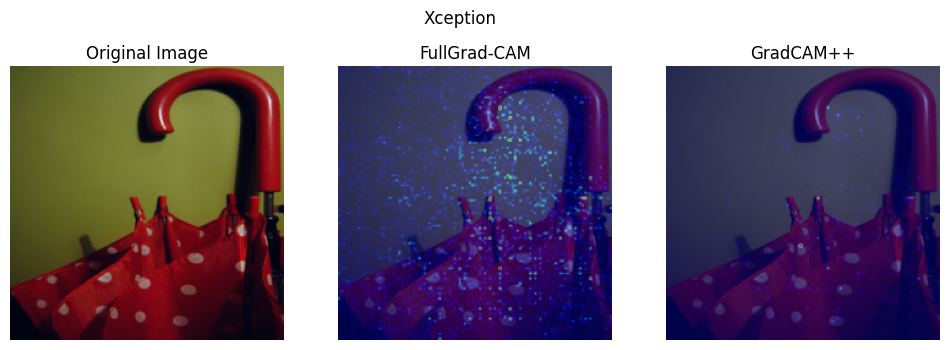

In [ ]:
def plot_comparison(image_tensor, fullgrad_cam, gradcam_plus, title="Comparison"):
    """Overlay FullGrad-CAM & GradCAM++ heatmaps on the image."""
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    image = (image * 255).astype(np.uint8)

    # Resize CAM maps to match image size
    fullgrad_cam = cv2.resize(fullgrad_cam, (image.shape[1], image.shape[0]))
    gradcam_plus = cv2.resize(gradcam_plus, (image.shape[1], image.shape[0]))

    # Normalize CAM maps
    fullgrad_cam = (fullgrad_cam - fullgrad_cam.min()) / (fullgrad_cam.max() - fullgrad_cam.min() + 1e-8)
    gradcam_plus = (gradcam_plus - gradcam_plus.min()) / (gradcam_plus.max() - gradcam_plus.min() + 1e-8)

    # Convert to uint8 heatmap
    heatmap_fullgrad = np.uint8(255 * fullgrad_cam)
    heatmap_gradcam_plus = np.uint8(255 * gradcam_plus)

    # Apply color maps
    heatmap_fullgrad = cv2.applyColorMap(heatmap_fullgrad, cv2.COLORMAP_JET)
    heatmap_gradcam_plus = cv2.applyColorMap(heatmap_gradcam_plus, cv2.COLORMAP_JET)

    # Convert to RGB (for matplotlib)
    heatmap_fullgrad = cv2.cvtColor(heatmap_fullgrad, cv2.COLOR_BGR2RGB)
    heatmap_gradcam_plus = cv2.cvtColor(heatmap_gradcam_plus, cv2.COLOR_BGR2RGB)

    # Overlay heatmaps on image
    overlay_fullgrad = cv2.addWeighted(image, 0.5, heatmap_fullgrad, 0.5, 0)
    overlay_gradcam_plus = cv2.addWeighted(image, 0.5, heatmap_gradcam_plus, 0.5, 0)

    # Plot images
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(overlay_fullgrad)
    axes[1].set_title("FullGrad-CAM")
    axes[1].axis("off")

    axes[2].imshow(overlay_gradcam_plus)
    axes[2].set_title("GradCAM++")
    axes[2].axis("off")

    plt.suptitle(title)
    plt.show()

# ==============================
# 8. RUN ON SAMPLE BATCH
# ==============================
for images, labels in data_loader:
    images = images.to(device)
    label = labels[0].item()

    fullgrad_cam = FullGradCAM(resnet, resnet_last_layer).generate_cam(images[0].unsqueeze(0), label)
    gradcam_plus_cam = GradCAMPlusPlus(resnet, resnet_last_layer).generate_cam(images[0].unsqueeze(0), label)

    plot_comparison(images[0], fullgrad_cam, gradcam_plus_cam, title="ResNet-50")
    fullgrad_cam_ex = FullGradCAM(xception, xception_last_layer).generate_cam(images[0].unsqueeze(0), label)
    gradcam_plus_cam_ex = GradCAMPlusPlus(xception, xception_last_layer).generate_cam(images[0].unsqueeze(0), label)

    plot_comparison(images[0], fullgrad_cam_ex, gradcam_plus_cam_ex, title="Xception")

    break  # Process one batch only

In [ ]:
import torch
import numpy as np

def deletion_score(model, image, heatmap, target_class, num_steps=50):
    """
    Measures how much the model's confidence drops as important pixels are removed.

    Returns:
        float: Deletion Score (Lower is better).
    """
    image = image.clone().detach()  # Copy input
    sorted_indices = np.argsort(-heatmap.flatten())  # Sort heatmap pixels by importance

    mask = np.ones_like(heatmap)  # Shape: (224, 224)

    confidence_drop = []

    for i in range(1, num_steps + 1):
        step_size = len(sorted_indices) // num_steps
        mask.flat[sorted_indices[:i * step_size]] = 0  # Remove top pixels

        # Convert mask to tensor & match image shape (C, H, W)
        mask_tensor = torch.tensor(mask, dtype=torch.float32,device=image.device).expand_as(image)

        perturbed_image = image.clone()
        perturbed_image *= mask_tensor  # Apply the mask

        output = model(perturbed_image.unsqueeze(0))  # Add batch dimension
        confidence = torch.nn.functional.softmax(output, dim=1)[0, target_class].item()

        confidence_drop.append(confidence)

    return np.trapezoid(confidence_drop)  # Compute area under the curve


def insertion_score(model, image, heatmap, target_class, num_steps=50):
    """
    Measures how much the model confidence increases as important pixels are added.

    Returns:
        float: Insertion Score (Higher is better).
    """
    image = image.clone().detach()
    sorted_indices = np.argsort(-heatmap.flatten())  # Sort by importance

    mask = np.zeros_like(heatmap)  # Shape: (224, 224)

    confidence_gain = []

    for i in range(1, num_steps + 1):
        step_size = len(sorted_indices) // num_steps
        mask.flat[sorted_indices[:i * step_size]] = 1  # Reveal pixels

        # Convert mask to tensor & match image shape (C, H, W)
        mask_tensor = torch.tensor(mask, dtype=torch.float32,device=image.device).expand_as(image)
        perturbed_image = image.clone()
        perturbed_image *= mask_tensor  # Apply the mask

        output = model(perturbed_image.unsqueeze(0))
        confidence = torch.nn.functional.softmax(output, dim=1)[0, target_class].item()

        confidence_gain.append(confidence)

    return np.trapezoid(confidence_gain)
heatmap_fullgrad = np.mean(heatmap_fullgrad, axis=-1)  # Convert to grayscale
heatmap_gradcam_plus = np.mean(heatmap_gradcam_plus, axis=-1)
heatmap_fullgrad_ex = np.mean(heatmap_fullgrad_ex, axis=-1)
heatmap_gradcam_plus_ex = np.mean(heatmap_gradcam_plus_ex, axis=-1)
# Compute Deletion and Insertion Scores
deletion = deletion_score(resnet, images[0], heatmap_fullgrad, label)
insertion = insertion_score(resnet, images[0], heatmap_fullgrad, label)

print(f"🔹 Deletion Score of fullgradcam on resnet: {deletion:.4f} (Lower is better)")
print(f"🔹 Insertion Score of fullgradcam on resnet: {insertion:.4f} (Higher is better)")

deletion = deletion_score(resnet, images[0], heatmap_gradcam_plus, label)
insertion = insertion_score(resnet, images[0], heatmap_gradcam_plus, label)

print(f"🔹 Deletion Score of gradcam plus plus on resnet: {deletion:.4f} (Lower is better)")
print(f"🔹 Insertion Score of gradcam plus plus on resnet: {insertion:.4f} (Higher is better)")

deletion = deletion_score(xception, images[0], heatmap_fullgrad_ex, label)
insertion = insertion_score(xception, images[0], heatmap_fullgrad_ex, label)

print(f"🔹 Deletion Score of fullgradcam on exception: {deletion:.4f} (Lower is better)")
print(f"🔹 Insertion Score of fullgradcam  on exception: {insertion:.4f} (Higher is better)")

deletion = deletion_score(xception, images[0], heatmap_gradcam_plus_ex, label)
insertion = insertion_score(xception, images[0], heatmap_gradcam_plus_ex, label)

print(f"🔹 Deletion Score of gradcam plus plus on exception: {deletion:.4f} (Lower is better)")
print(f"🔹 Insertion Score of gradcam plus plus on exception: {insertion:.4f} (Higher is better)")


🔹 Deletion Score of fullgradcam on resnet: 0.7663 (Lower is better)
🔹 Insertion Score of fullgradcam on resnet: 0.1681 (Higher is better)
🔹 Deletion Score of gradcam plus plus on resnet: 0.0565 (Lower is better)
🔹 Insertion Score of gradcam plus plus on resnet: 0.1121 (Higher is better)
🔹 Deletion Score of fullgradcam on exception: 0.0051 (Lower is better)
🔹 Insertion Score of fullgradcam  on exception: 0.0037 (Higher is better)
🔹 Deletion Score of gradcam plus plus on exception: 0.0581 (Lower is better)
🔹 Insertion Score of gradcam plus plus on exception: 0.0987 (Higher is better)
